In [1]:
import spikeinterface.full as si

In [2]:
import spyglass.spikesorting as sgs

[2023-06-06 16:21:53,595][INFO]: Connecting kyu@lmf-db.cin.ucsf.edu:3306
[2023-06-06 16:21:53,638][INFO]: Connected kyu@lmf-db.cin.ucsf.edu:3306


helper functions

In [9]:
import json
import numpy as np

def get_recording(nwb_file_name, shank_id):
    recording_path = (sgs.SpikeSortingRecording & {"nwb_file_name":nwb_file_name,
                                                   "sort_group_id":shank_id}).fetch("recording_path")[0]
    recording = si.load_extractor(recording_path)
    if recording.get_num_segments()>1:
        recording = si.concatenate_recordings([recording])
    return recording

def get_sorting(nwb_file_name, shank_id):
    sorting_path = (sgs.SpikeSorting & {"nwb_file_name":nwb_file_name,
                                        "sort_group_id":shank_id}).fetch("sorting_path")[0]
    sorting = si.load_extractor(sorting_path)

    return sorting

def open_json(path):
    with open(path, 'r') as f:
        c = json.load(f)
    return c

def get_curation_labels(nwb_file_name, shank_id, path_to_sorting_curation_repo):
    curation_uri = (sgs.CurationFigurl & {"nwb_file_name": nwb_file_name,
                                          "sort_group_id":shank_id}).fetch("new_curation_uri")[0]
    local_path = curation_uri.replace('gh://LorenFrankLab/sorting-curations/main/', path_to_sorting_curation_repo)
    curation_labels = open_json(local_path)
    return curation_labels


def get_units_to_remove(curation_labels):
    exclude_labels = ['noise', 'reject', 'mua']
    units_to_remove = []
    for unit_id, labels in curation_labels['labelsByUnit'].items():
        if np.sum([i in exclude_labels for i in labels])>0:
            units_to_remove.append(int(unit_id))
    return units_to_remove

def curate_sorting(sorting, curation_labels, skip_merge=True):
    if curation_labels['labelsByUnit']:
        units_to_remove = get_units_to_remove(curation_labels)
        sorting = sorting.remove_units(units_to_remove)
    if curation_labels['mergeGroups'] and skip_merge==False:
        sorting = si.MergeUnitsSorting(parent_sorting=sorting,
                                       units_to_merge=curation_labels['mergeGroups'],
                                      )
    return sorting

Define NWB file names

In [4]:
nwb_file_name1 = "L520230417_.nwb"
nwb_file_name2 = "L520230420_.nwb"

shank_id = 0

Load recording

In [5]:
recording1 = get_recording(nwb_file_name1, shank_id)
recording2 = get_recording(nwb_file_name2, shank_id)

Load sorting

In [6]:
sorting1 = get_sorting(nwb_file_name1, shank_id)
sorting2 = get_sorting(nwb_file_name2, shank_id)

get manual curation labels

In [11]:
# change this to path on your system
!cd ~/repos/sorting-curations && git pull origin main
path_to_sorting_curation_repo = '/home/kyu/repos/sorting-curations/'

remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 993 bytes | 43.00 KiB/s, done.
From https://github.com/LorenFrankLab/sorting-curations
 * branch            main       -> FETCH_HEAD
   c50b37b..7e6fff1  main       -> origin/main
Updating c50b37b..7e6fff1
Fast-forward
 khl02007/L520230522_.nwb_02_r1/0/curation.json | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [12]:
curation_labels1 = get_curation_labels(nwb_file_name1, shank_id, path_to_sorting_curation_repo)
curation_labels2 = get_curation_labels(nwb_file_name2, shank_id, path_to_sorting_curation_repo)

Update the sorting-curations repo (make sure to change path)

apply curation

In [13]:
sorting1 = curate_sorting(sorting1, curation_labels1)
sorting2 = curate_sorting(sorting2, curation_labels2)

extract waveforms

In [14]:
waveform_extractor1 = si.extract_waveforms(recording1, sorting1, folder="/tmp/we1",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47
                                          )

extract waveforms memmap:   0%|          | 0/2450 [00:00<?, ?it/s]

In [15]:
waveform_extractor2 = si.extract_waveforms(recording2, sorting2, folder="/tmp/we2",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47
                                          )

extract waveforms memmap:   0%|          | 0/1203 [00:00<?, ?it/s]

In [16]:
import sklearn.metrics.pairwise

templates = waveform_extractor1.get_all_templates()
s = templates.shape
templates_flat = templates.reshape(s[0], -1)

templates_other = waveform_extractor2.get_all_templates()
s_other = templates_other.shape
templates_other_flat = templates_other.reshape(s_other[0], -1)

similarity = sklearn.metrics.pairwise.cosine_similarity(templates_flat, templates_other_flat)


In [17]:
import matplotlib.pyplot as plt

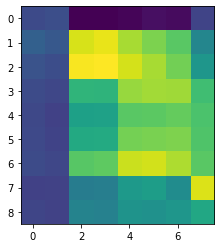

In [18]:
plt.imshow(similarity)

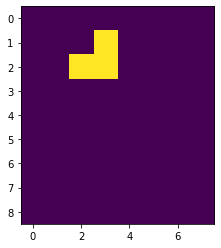

In [19]:
plt.imshow(similarity>0.9)

In [20]:
agreement_scores = si.compute_template_similarity(waveform_extractor1,
                                                  waveform_extractor_other=waveform_extractor2,
                                                  )

In [21]:
import matplotlib.pyplot as plt

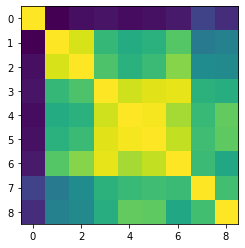

In [22]:
plt.imshow(agreement_scores)

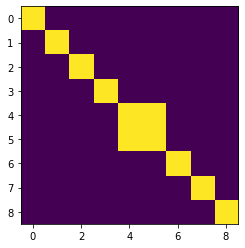

In [23]:
plt.imshow(agreement_scores>0.95)

In [24]:
comp = si.compare_templates(waveform_extractor1, waveform_extractor2,
                            we1_name=nwb_file_name1, we2_name=nwb_file_name2,
                            verbose=True)

Agreement scores...


ValueError: Shape of passed values is (9, 9), indices imply (9, 8)